In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Data import:

In [3]:
# Read in data as a pandas DataFrame
ctq_a1_df = pd.read_csv("../data/CTQ_20191008.csv")

# Keep only the 'redcap_id' column as well as all columns that start with 'ctq'
ctq_a1_df = ctq_a1_df[['redcap_id'] + [col for col in ctq_a1_df if col.startswith('ctq')]]

# Set index to 'redcap_id'
ctq_a1_df = ctq_a1_df.set_index('redcap_id')

In [5]:
ctq_a1_df.head(2)

,ctq_your_childhood_timestamp,ctqq_1,ctqq_2,ctqq_3,ctqq_4,ctqq_5,ctqq_6,ctqq_7,ctqq_8,ctqq_9,...,ctqq_20,ctqq_21,ctqq_22,ctqq_23,ctqq_24,ctqq_25,ctqq_26,ctqq_27,ctqq_28,ctq_your_childhood_complete
redcap_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,1.0,5.0,3.0,1.0,5.0,1.0,5.0,1.0,1.0,...,1.0,1.0,5.0,1.0,1.0,1.0,5.0,1.0,5.0,2
2,13-08-19 10:36,4.0,3.0,5.0,3.0,1.0,1.0,2.0,5.0,5.0,...,1.0,1.0,2.0,2.0,1.0,4.0,5.0,1.0,1.0,2


In [6]:
ctq_a1_df.shape

(84, 30)

## Check and remove duplicated redcap_ids:

In [7]:
# Check for duplicates:
ctq_a1_df[ctq_a1_df.index.duplicated()]

,ctq_your_childhood_timestamp,ctqq_1,ctqq_2,ctqq_3,ctqq_4,ctqq_5,ctqq_6,ctqq_7,ctqq_8,ctqq_9,...,ctqq_20,ctqq_21,ctqq_22,ctqq_23,ctqq_24,ctqq_25,ctqq_26,ctqq_27,ctqq_28,ctq_your_childhood_complete
redcap_id,,,,,,,,,,,,,,,,,,,,,


In [8]:
# remove duplicates if any:
ctq_a1_df = ctq_a1_df[~ctq_a1_df.index.duplicated(keep ='first')]

## Subsetting data to questionnaire answers only:

In [9]:
# Here using iloc I keep all rows but remove the first and last columns
ctq_a1_subset_df = ctq_a1_df.iloc[:, 1:len(ctq_a1_df.columns)-1]

In [10]:
ctq_a1_subset_df.head(2)

,ctqq_1,ctqq_2,ctqq_3,ctqq_4,ctqq_5,ctqq_6,ctqq_7,ctqq_8,ctqq_9,ctqq_10,...,ctqq_19,ctqq_20,ctqq_21,ctqq_22,ctqq_23,ctqq_24,ctqq_25,ctqq_26,ctqq_27,ctqq_28
redcap_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,5.0,3.0,1.0,5.0,1.0,5.0,1.0,1.0,5.0,...,5.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,1.0,5.0
2,4.0,3.0,5.0,3.0,1.0,1.0,2.0,5.0,5.0,1.0,...,1.0,1.0,1.0,2.0,2.0,1.0,4.0,5.0,1.0,1.0


In [11]:
# Here the shape shows 84 patients and 28 questions:
ctq_a1_subset_df.shape

(84, 28)

## Replace 99's (no answer) with NaNs:

In [12]:
# Pandas replace() method allows us to replace a value or a list of values accross a DataFrame
ctq_a1_subset_df = ctq_a1_subset_df.replace(99, np.NaN)

## Check if any patient has not filled the questionnaire and remove:

In [13]:
# Here isnull() returns True if NaN value is present and .all(1) returns True if all values are NaNs for the row
ctq_empty_l = ctq_a1_subset_df[ctq_a1_subset_df.isnull().all(1)].index.tolist()
ctq_empty_l

[7, 29, 35, 63, 64, 69, 78]

In [14]:
# drop() is a pandas method for removing rows or columns:
ctq_a1_subset_df = ctq_a1_subset_df.drop(ctq_empty_l)

## Check if all values are between 1 and 5 and return redcap_ids values that are not:

In [16]:
# Numpy's unique() method returns onyl unique occurences of values within the DataFrame
# Here I also make sure it is not a NaN value
[x for x in np.unique(ctq_a1_subset_df) if not np.isnan(x)]

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [18]:
out_of_bounds_bool_s = ctq_a1_subset_df[~((ctq_a1_subset_df >= 1) & (ctq_a1_subset_df <= 5))].T.any()
out_of_bounds_bool_s[out_of_bounds_bool_s]

redcap_id
21    True
23    True
41    True
dtype: bool

## Get Total Subscales Scores per Patient DataFrame and save to file:

In [19]:
# Here I create a dictionary of subscales titles (keys) with as (values) lists of the question numbers 
# corresponding to a subscale

# Name subscales and assign respective question ids:
subscales_d = {"emotional_abuse": [3,8,14,18,25], "physical_abuse": [9,11,12,15,17],
            "sexual_abuse": [20,21,23,24,27], "emotional_neglect": [5,7,13,19,28],
            "physical_neglect": [1,2,4,6,26], "minimization_denial": [10,16,22]}

# Add ctqq_ string to front of question number since these are the column values of the ctq_maws_a1_subset_df DataFrame
# I only wrote this for loop because I was too lazy to manually add "ctqq_" in front of the question numbers.
for key, value in subscales_d.items():
    subscales_d[key] = ["ctqq_" + str(i) for i in value]

### Get and reverse reverse coded questions:

In [20]:
def reverse_score(x):
    """
    Function to reverse-code scores using indexes from list below:
    
    In this function I emplouy a little trick using python's list indexing that uses the index of the list
    to return the opposite number of the one supplied to the function (x).
    Let's say x=2, the list value at index -2 is 4! This works for all values of x between 1-5
    """
    score_values_l = [1,2,3,4,5]
    
    if not np.isnan(x):
    
        try:
            return score_values_l[-int(x)]
        except IndexError:
            print(x)

In [21]:
# Here I enumerate and append 'ctqq' to the reverse coded questions
reverse_coded_questions_l = [5,7,13,19,28,2,26]
reverse_l = ["ctqq_" + str(i) for i in reverse_coded_questions_l]

In [22]:
# applymap is a pandas method to applyt a function to all values of a DataFrame
# Here however it is only applied to the values of columns in the 'rever_l' list created above
ctq_a1_subset_df[reverse_l] = ctq_a1_subset_df[reverse_l].copy().applymap(reverse_score)

6.0


In [23]:
# Total scores are computed in new DataFrame here by taking:
# equation 1: ( sum of scores in subscale / ( amount of questions in subscale - unanswered questions(NaN) ) )

# Here I generate a new DataFrame (total_scores_df) with the same index as the ctq_a1_subset_df DataFrame
total_scores_df = pd.DataFrame(pd.DataFrame(index=ctq_a1_subset_df.index))

# For loop across keys of the subscales_d dictionary, key will therefore be the name of a subscales
# which we will use to create the columns in the new DataFrame
for key in subscales_d.keys():
    # See equation 1 above
    total_scores_df[key+"_prorated"] = ctq_a1_subset_df[subscales_d[key]].sum(axis=1)/(len(ctq_a1_subset_df[subscales_d[key]].columns)-ctq_a1_subset_df[subscales_d[key]].isnull().sum(axis=1))
    # Simply takes the sum of a row in columns of subscale questions only with pandas's sum() method
    total_scores_df[key+"_sum"] = ctq_a1_subset_df[subscales_d[key]].sum(axis=1)
    # Check if a row contains any NaNs in columns of subscale questions only
    total_scores_df[key+"_contains_nan"] = ctq_a1_subset_df[subscales_d[key]].isnull().any(axis=1)
    # Count the occurences of those NaNs
    total_scores_df[key+"_nan_counts"] = ctq_a1_subset_df[subscales_d[key]].isnull().sum(axis=1)
    
# Check if a row contains any NaNS
total_scores_df["contains_nan"] = ctq_a1_subset_df.isnull().any(axis=1)


## HERE is a great example of programming's rule n.2: Never repeat yourself!

In [24]:
# GOOD PROGRAMMING:
def return_custom_rank_value(score_sum, low_non, high_non, low_low, high_low, low_mod, high_mod, low_hig):
    if score_sum >= low_non and score_sum <= high_non:
        rank = "None"
    elif score_sum >= low_low and score_sum <= high_low:
        rank = "Low"
    elif score_sum >= low_mod and score_sum <= high_mod:
        rank = "Moderate"
    elif score_sum >= low_hig:
        rank = "High"
    else:
        rank = np.nan
    
    return rank

# Add rank columns
def assign_rank(row):
    emotional_abuse_rank = return_custom_rank_value(row.emotional_abuse_sum, 5, 8, 9, 12, 13, 15, 16)
    physical_abuse_rank = return_custom_rank_value(row.physical_abuse_sum, 5, 7, 8, 9, 10, 12, 12)
    sexual_abuse_rank = return_custom_rank_value(row.sexual_abuse_sum, 5, 5, 6, 7, 8, 12, 13)
    emotional_neglect_rank = return_custom_rank_value(row.emotional_neglect_sum, 5, 9, 10, 14, 15, 17, 18)
    physical_neglect_rank = return_custom_rank_value(row.physical_neglect_sum, 5, 7, 8, 9, 10, 12, 13)
    
    return pd.Series((emotional_abuse_rank, physical_abuse_rank, sexual_abuse_rank, 
                      emotional_neglect_rank, physical_neglect_rank))

In [25]:
# BAD PROGRAMMING:
# Add rank columns
# def assign_rank(row):
#     score_sum = row.emotional_abuse_sum
#     if score_sum >= 5 and score_sum <= 8:
#         emotional_abuse_rank = "None"
#     elif score_sum >= 9 and score_sum <= 12:
#         emotional_abuse_rank = "Low"
#     elif score_sum >= 13 and score_sum <= 15:
#         emotional_abuse_rank = "Moderate"
#     elif score_sum >= 16:
#         emotional_abuse_rank = "High"
#     else:
#         emotional_abuse_rank = np.nan
            
#     score_sum = row.physical_abuse_sum
#     if score_sum >= 5 and score_sum <= 7:
#         physical_abuse_rank = "None"
#     elif score_sum >= 8 and score_sum <= 9:
#         physical_abuse_rank = "Low"
#     elif score_sum >= 10 and score_sum <= 12:
#         physical_abuse_rank = "Moderate"
#     elif score_sum >= 13:
#         physical_abuse_rank = "High"
#     else:
#         physical_abuse_rank = np.nan
            
#     score_sum = row.sexual_abuse_sum
#     if score_sum == 5:
#         sexual_abuse_rank = "None"
#     elif score_sum >= 6 and score_sum <= 7:
#         sexual_abuse_rank = "Low"
#     elif score_sum >= 8 and score_sum <= 12:
#         sexual_abuse_rank = "Moderate"
#     elif score_sum >= 13:
#         sexual_abuse_rank = "High"
#     else:
#         sexual_abuse_rank = np.nan
            
#     score_sum = row.emotional_neglect_sum
#     if score_sum >= 5 and score_sum <= 9:
#         emotional_neglect_rank = "None"
#     elif score_sum >= 10 and score_sum <= 14:
#         emotional_neglect_rank = "Low"
#     elif score_sum >= 15 and score_sum <= 17:
#         emotional_neglect_rank = "Moderate"
#     elif score_sum >= 18:
#         emotional_neglect_rank = "High"
#     else:
#         emotional_neglect_rank = np.nan
            
#     score_sum = row.physical_neglect_sum
#     if score_sum >= 5 and score_sum <= 7:
#         physical_neglect_rank = "None"
#     elif score_sum >= 8 and score_sum <= 9:
#         physical_neglect_rank = "Low"
#     elif score_sum >= 10 and score_sum <= 12:
#         physical_neglect_rank = "Moderate"
#     elif score_sum >= 13:
#         physical_neglect_rank = "High"
#     else:
#         physical_neglect_rank = np.nan
        
#     return pd.Series((emotional_abuse_rank, physical_abuse_rank, sexual_abuse_rank, 
#                       emotional_neglect_rank, physical_neglect_rank))

In [26]:
total_scores_df[['emotional_abuse_rank', 'physical_abuse_rank', 'sexual_abuse_rank', 
                 'emotional_neglect_rank', 'physical_neglect_rank']] = total_scores_df.apply(assign_rank, axis=1)

In [27]:
total_scores_df = total_scores_df.reindex(sorted(total_scores_df.columns), axis=1)

In [28]:
total_scores_df.round(1)

,contains_nan,emotional_abuse_contains_nan,emotional_abuse_nan_counts,emotional_abuse_prorated,emotional_abuse_rank,emotional_abuse_sum,emotional_neglect_contains_nan,emotional_neglect_nan_counts,emotional_neglect_prorated,emotional_neglect_rank,...,physical_neglect_contains_nan,physical_neglect_nan_counts,physical_neglect_prorated,physical_neglect_rank,physical_neglect_sum,sexual_abuse_contains_nan,sexual_abuse_nan_counts,sexual_abuse_prorated,sexual_abuse_rank,sexual_abuse_sum
redcap_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,0,2.2,Low,11.0,False,0,1.0,None,...,False,0,1.0,None,5.0,False,0,1.0,None,5.0
2,False,False,0,4.8,High,24.0,False,0,4.8,High,...,False,0,2.4,Moderate,12.0,False,0,1.2,Low,6.0
3,False,False,0,1.0,None,5.0,False,0,4.2,High,...,False,0,3.0,High,15.0,False,0,1.2,Low,6.0
4,False,False,0,1.0,None,5.0,False,0,2.8,Low,...,False,0,1.2,None,6.0,False,0,1.2,Low,6.0
5,False,False,0,1.0,None,5.0,False,0,1.0,None,...,False,0,1.0,None,5.0,False,0,1.0,None,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,False,False,0,1.6,None,8.0,False,0,2.2,Low,...,False,0,1.2,None,6.0,False,0,1.0,None,5.0
81,False,False,0,1.6,None,8.0,False,0,3.0,Moderate,...,False,0,1.2,None,6.0,False,0,1.0,None,5.0
82,False,False,0,3.4,High,17.0,False,0,2.4,Low,...,False,0,1.0,None,5.0,False,0,2.0,Moderate,10.0


### Save dataframe to csv file:

In [30]:
total_scores_df.round(1).to_csv("../data/CTQ_total_subscale_scores_ALL.csv")

# Plotting Examples:

## Missing values:

In [34]:
total_scores_missing_df = total_scores_df[[col for col in total_scores_df if col.endswith('contains_nan')]]

In [35]:
total_scores_missing_df = total_scores_missing_df[(total_scores_missing_df.contains_nan == True)].sum(axis=1)

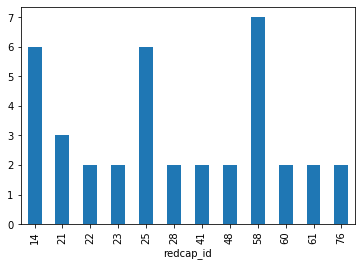

In [36]:
total_scores_missing_df.plot.bar()

## Plotting

### Keep only columns with prorated data:

In [37]:
total_scores_prorated_df = total_scores_df[[col for col in total_scores_df if col.endswith('prorated')]]

In [38]:
total_scores_prorated_df

,emotional_abuse_prorated,emotional_neglect_prorated,minimization_denial_prorated,physical_abuse_prorated,physical_neglect_prorated,sexual_abuse_prorated
redcap_id,,,,,,
1,2.2,1.0,4.000000,1.6,1.0,1.0
2,4.8,4.8,1.333333,4.0,2.4,1.2
3,1.0,4.2,1.666667,1.0,3.0,1.2
4,1.0,2.8,3.000000,1.4,1.2,1.2
5,1.0,1.0,5.000000,1.2,1.0,1.0
...,...,...,...,...,...,...
80,1.6,2.2,2.666667,1.0,1.2,1.0
81,1.6,3.0,3.666667,1.4,1.2,1.0
82,3.4,2.4,2.000000,3.2,1.0,2.0


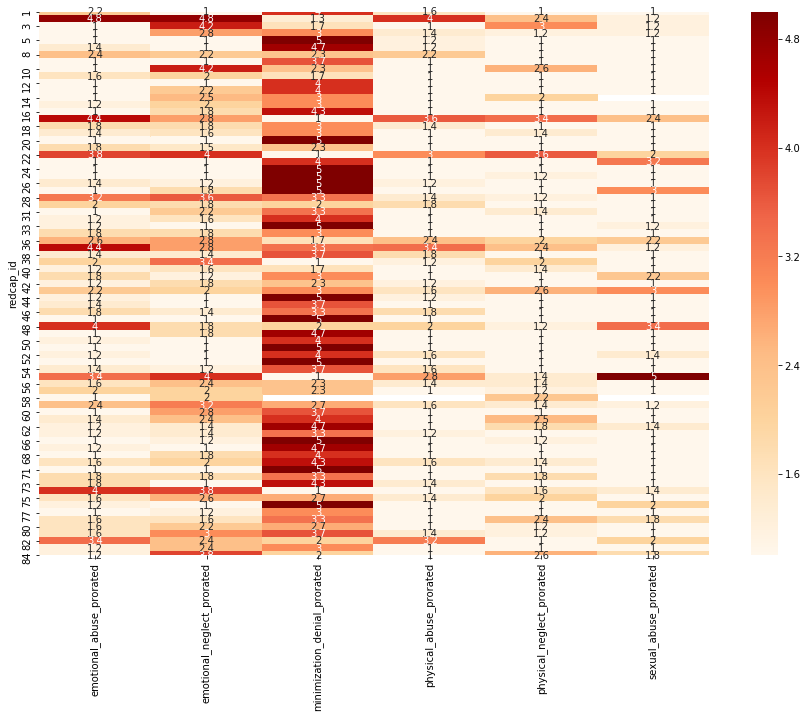

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(total_scores_prorated_df, annot=True, cmap="OrRd")